In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\juanc\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
import pylab as pl
from matplotlib import pyplot as plt

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

### Trabajar con el dataset original preprocesado para eliminar ruido, nulos y duplicados
df = pd.read_csv('../data/preprocessed.csv')

# Eliminar las filas con valores faltantes, si las hay
df.dropna(inplace=True)

# Convertir las columnas categóricas a numéricas
encoder = LabelEncoder()
df['RainToday'] = encoder.fit_transform(df['RainToday'])
df['RainTomorrow'] = encoder.fit_transform(df['RainTomorrow'])

# Seleccionar las características y la columna objetivo
X = df.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir9am', 'WindDir3pm', 'RainTomorrow'], axis=1)
y = df['RainTomorrow']

# Escalar los datos para normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convertir la variable objetivo a formato categórico (si es necesario)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Crear el modelo de red neuronal
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas para clasificación binaria
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat))




Epoch 1/20


1891/1891 [==============================] - 4s 2ms/step - loss: 0.3610 - accuracy: 0.8404 - val_loss: 0.3318 - val_accuracy: 0.8591
Epoch 2/20
1891/1891 [==============================] - 4s 2ms/step - loss: 0.3446 - accuracy: 0.8501 - val_loss: 0.3309 - val_accuracy: 0.8608
Epoch 3/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.3421 - accuracy: 0.8513 - val_loss: 0.3308 - val_accuracy: 0.8596
Epoch 4/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.3418 - accuracy: 0.8502 - val_loss: 0.3275 - val_accuracy: 0.8616
Epoch 5/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.3397 - accuracy: 0.8520 - val_loss: 0.3264 - val_accuracy: 0.8608
Epoch 6/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.3375 - accuracy: 0.8531 - val_loss: 0.3264 - val_accuracy: 0.8588
Epoch 7/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.3377 - accuracy: 0.8514 - val_loss: 0.3286 - val_accu

In [5]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred[:, 1]]  # Convertir las predicciones a clases binarias

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el reporte de clasificación por clase
class_report = classification_report(y_test, y_pred_classes)
print("\nReporte de Clasificación por Clase:")
print(class_report)

473/473 [==============================] - 1s 1ms/step
Matriz de Confusión:
[[11243   637]
 [ 1455  1790]]

Reporte de Clasificación por Clase:
              precision    recall  f1-score   support

           0       0.89      0.95      0.91     11880
           1       0.74      0.55      0.63      3245

    accuracy                           0.86     15125
   macro avg       0.81      0.75      0.77     15125
weighted avg       0.85      0.86      0.85     15125



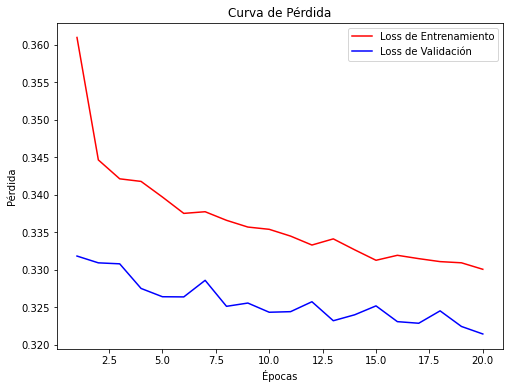

In [8]:
# Obtener la pérdida en el conjunto de entrenamiento y prueba
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de la curva de pérdida
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'r', label='Loss de Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Loss de Validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

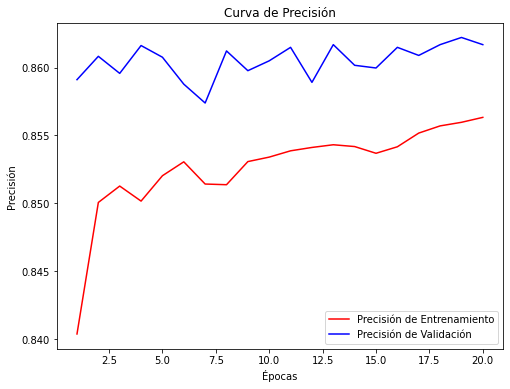

In [9]:
# Obtener la precisión en el conjunto de entrenamiento y prueba
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear un gráfico de la curva de precisión
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, 'r', label='Precisión de Entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de Validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [10]:
# Obtener las probabilidades de predicción para la clase positiva
y_pred_probs = model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

AttributeError: 'Sequential' object has no attribute 'predict_proba'